In [121]:
import pandas as pd
import pandas.tools.plotting
import numpy as np
# from scipy import stats
# from sklearn import linear_model

import datetime as dt
import matplotlib.pyplot as plt

from fbprophet import Prophet

import importlib
import sys

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 4)

sys.path.insert(0, '/Users/abertran/Documents/gitRepositories/Steve_notebooks')
from capacityHelpers2 import *

dir_name='/Users/abertran/Documents/gitRepositories/Steve_notebooks/SteveBobNotebooks/data/'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(dir_name) if isfile(join(dir_name, f))]

type(onlyfiles)

Populating the interactive namespace from numpy and matplotlib


list

In [132]:
dbCpuCapacity = 50

# variables determined by given pod
pod = pd.read_csv('/Users/abertran/Documents/gitRepositories/Steve_notebooks/SteveBobNotebooks/lookups/podList.csv')
pod.set_index('pod', inplace=True)

numNodes = pod.loc[podName]['servers']
topNodes = numNodes - 1
capacity = topNodes * dbCpuCapacity

holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': getHolidays(start='20-Nov-2016', end=IRdate).strftime('%d-%b-%Y'),
    'lower_window': -1,
    'upper_window': 1,
})

pod_list=set([i.split('-', 1)[0] for i in onlyfiles])
for podName in pod_list:
    # various dates to be aware of
    IRdate = pod.loc[podName]['IRdate']
    
    # dbCPU changepoints and reasons
    cpd = pod.loc[podName]['cpd'].split(',') if not pd.isnull(pod.loc[podName]['cpd']) else None
    cpt = pod.loc[podName]['cpt'].split(',') if not pd.isnull(pod.loc[podName]['cpt']) else None
    cpl = {'Title': cpt, 'changeDate': cpd} if not pd.isnull(pod.loc[podName]['cpd']) else None
    dbCPUchangePoints = pd.DataFrame(data=cpl).reindex() if not pd.isnull(pod.loc[podName]['cpd']) else None
    dbCPUchangePointsAsDate = pd.to_datetime(cpd)

eu5
na41
na54
eu8
na55
na57
na61
na6
na39
na62
na69
ap5
eu10
na37
na67
eu12
na76
na77
na99
ap7
ap3
na74
eu15
eu11
eu4
eu6
na21
na51
na47
na50
na53
na87
ap0
na63
na29
na64
na7
na59
na78
na73
na48
eu14
na46
na88
na35
na65
na30
na32
na56
na43
na68
ap9
na86
na66
na33
na38
eu7
na31
na79
ap6
na49
na8
na34
na58
na60
na45
gs0
na40
eu1
na42
na44
na52
ap1
ap4
na3
eu9
na72
eu13
na24


In [99]:
podName='na6'









Populating the interactive namespace from numpy and matplotlib


In [100]:
#sys.path.insert(0, '/Users/abertran/Documents/gitRepositories/Steve_notebooks')
#from capacityHelpers2 import *

# fetch data for analysis
data = importArgusTimeSeriesCSV('/Users/abertran/Documents/gitRepositories/Steve_notebooks/SteveBobNotebooks/data/' + podName + '-cpu-capacity.csv')

tsCPU = pd.Series.to_frame(getRankedTimeSeries(data, topNodes).sum(axis=1))
topNodes
tsCPU2 = pd.Series.to_frame(getRankedTimeSeries3(data, topNodes).sum(axis=1))

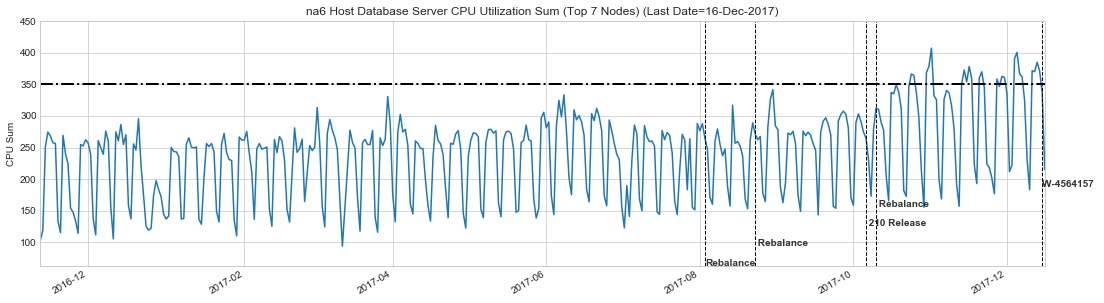

In [101]:
tsCPU.shape

plotTimeSeries(tsCPU, 
    yAxisLabel='CPU Sum', 
    yLower=None, 
    yUpper=int(capacity)+100,
    chartTitle=podName + ' Host Database Server CPU Utilization Sum (Top '+ str(topNodes) +' Nodes)',
    changePoints=dbCPUchangePoints,
    capacity=capacity)

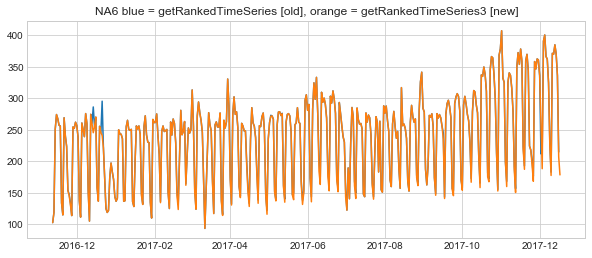

In [102]:
plt.plot(tsCPU)
plt.plot(tsCPU2)
plt.title('NA6 blue = getRankedTimeSeries [old], orange = getRankedTimeSeries3 [new]')
plt.show()


In [103]:
(np.min(tsCPU2.index),np.max(tsCPU2.index))

(Timestamp('2016-11-12 00:00:00'), Timestamp('2017-12-17 00:00:00'))

In [104]:
tsCPU2.to_csv('/Users/abertran/Documents/Data/CPUUtilRegModel/new_cpu_data.csv')

Prophet

In [105]:
tsCPU2['ds'] = tsCPU2.index
tsCPU2.columns = ['y','ds']

m = Prophet(yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=False,
                holidays=holidays, changepoints=dbCPUchangePointsAsDate)
m.fit(tsCPU2)

future = m.make_future_dataframe(periods=360)
future['cap'] = 50*topNodes
forecast = m.predict(future)

# plot
#plt.style.use('seaborn-whitegrid')
#fig, ax = plt.subplots(figsize=(18,5))
#sub1 = m.plot(forecast, uncertainty=True, xlabel='', ylabel='ms', ax=ax)

#axes = sub1.get_axes()
#axes[0].set_ylabel('CPU Utilization (%)', fontsize=14)
#axes[0].set_ylim(0,50*topNodes*1.2)
#axes[0].set_title(podName , fontsize=20)
#axes[0].axvline(x=IRdate, c='gray', lw=4, alpha=0.5)
#axes[0].text(x=(pd.to_datetime(IRdate) - pd.Timedelta('15 days')), y=15, s='IR Date', color='black', fontsize=16, fontweight='bold', alpha=0.8)

#_ = plt.show()

In [106]:
(tsCPU2.shape,future.shape)
tsCPU2.head()

,y,ds
Timestamp,,
2016-11-12,102.917998,2016-11-12
2016-11-13,118.909998,2016-11-13
2016-11-14,251.159998,2016-11-14
2016-11-15,274.434998,2016-11-15
2016-11-16,267.975000,2016-11-16


Quantile

In [107]:
import rpy2;
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

tsQuantile=tsCPU2.copy()
end_quantile_forecast_date=tsQuantile['ds'].iloc[(len(tsQuantile)-1)]
start_quantile_forecast_date=end_quantile_forecast_date - datetime.timedelta(6*365/12+1)
futureQuantile=future.copy()

mask=(tsQuantile['ds']>=start_quantile_forecast_date) & (tsQuantile['ds'] <= end_quantile_forecast_date)
tsQuantile=tsQuantile.loc[mask]
mask=(futureQuantile['ds']>end_quantile_forecast_date) 
futureQuantile=futureQuantile.loc[mask]

#tsQuantile['indices'] = pd.Series([0, 1+(tsQuantile['ds']-tsQuantile['ds'].iloc[0]).astype('timedelta64[D]')])
#tsQuantile['indices'] = 1+(tsQuantile['ds']-tsQuantile['ds'].iloc[0]).astype('timedelta64[D]')
#indices=pd.Series([0, 1+(tsQuantile['ds']-tsQuantile['ds'].iloc[0]).astype('timedelta64[D]')])
tsQuantile['indices'] = 1+(tsQuantile['ds']-tsQuantile['ds'].iloc[0]).astype('timedelta64[D]')


futureQuantile['indices'] = 1+(futureQuantile['ds']-tsQuantile['ds'].iloc[0]).astype('timedelta64[D]')

end_quantile_forecast_date=tsQuantile['ds'].iloc[(len(tsQuantile)-1)]
start_quantile_forecast_date=end_quantile_forecast_date - datetime.timedelta(6*365/12+1)

rdf_model_train = pandas2ri.py2ri(tsQuantile[['indices','y']])
indices_to_forecast_r = pandas2ri.py2ri(futureQuantile[['indices']])

quantreg = importr('quantreg')

robjects.r('''
           med_coeff <- function(train) {
                    library(quantreg)
                    train1.rf <- rq(y ~ indices, data = train, tau=0.5)
            }
            ''')
robjects.r('''
           ninetyp_coeff <- function(train) {
                    library(quantreg)
                    train1.rf <- rq(y ~ indices, data = train, tau=0.9)
            }
            ''')

#Predict
robjects.r('''
           g <- function(model,indices_to_forecast) {
                    pred=predict(model,data.frame(index=indices_to_forecast),interval="confidence")
                    #pred <- as.data.frame(predict(model, test))
                    pred = as.data.frame(pred)

            }
            ''')

#Model and forecast for 50percentile (median) quantile
r_f = robjects.globalenv['med_coeff']
rf_model=(r_f(rdf_model_train))
#model_med=dict(zip(rf_model.names, list(rf_model)))
med_fitted_values=(np.array(rf_model.rx('fitted.values'))).flatten()
med_coeff=(np.array(rf_model.rx('coefficients'))).flatten()

r_g = robjects.globalenv['g']
pred_median=pandas2ri.ri2py(r_g(rf_model,indices_to_forecast_r))


##Model and forecast for 90percentile quantile
r_f = robjects.globalenv['ninetyp_coeff']
rf_model=(r_f(rdf_model_train))
#model_ninetyp=dict(zip(rf_model.names, list(rf_model)))
ninetyp_fitted_values=(np.array(rf_model.rx('fitted.values'))).flatten()
ninetyp_coeff=(np.array(rf_model.rx('coefficients'))).flatten()


r_g = robjects.globalenv['g']
pred_ninetyp=pandas2ri.ri2py(r_g(rf_model,indices_to_forecast_r))
type(pred_ninetyp)


#Set-up the model quantile lines
x_start_med_line=tsQuantile.iloc[0]['ds']
x_end_med_line=tsQuantile.iloc[(len(tsQuantile)-1)]['ds']
y_start_med_line=med_coeff[0]+med_coeff[1]*tsQuantile.iloc[0]['indices']
y_end_med_line=med_coeff[0]+med_coeff[1]*tsQuantile.iloc[(len(tsQuantile)-1)]['indices']
y_start_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*tsQuantile.iloc[0]['indices']
y_end_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*tsQuantile.iloc[(len(tsQuantile)-1)]['indices']

#Set-up the forecast quantile lines
x_forecast_start_med_line=futureQuantile.iloc[0]['ds']
x_forecast_end_med_line=futureQuantile.iloc[(len(futureQuantile)-1)]['ds']
y_forecast_start_med_line=med_coeff[0]+med_coeff[1]*futureQuantile.iloc[0]['indices']
y_forecast_end_med_line=med_coeff[0]+med_coeff[1]*futureQuantile.iloc[(len(futureQuantile)-1)]['indices']
y_forecast_start_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*futureQuantile.iloc[0]['indices']
y_forecast_end_extrap_line=ninetyp_coeff[0]+ninetyp_coeff[1]*futureQuantile.iloc[(len(futureQuantile)-1)]['indices']

#Set-up the confidence interval for the forecast quantile lines
#50P
y_forecast_start_extrap_lwr_med=pred_median.iloc[0]['lower']
y_forecast_start_extrap_hghr_med=pred_median.iloc[0]['higher']
y_forecast_end_extrap_lwr_med=pred_median.iloc[(len(futureQuantile)-1)]['lower']
y_forecast_end_extrap_hghr_med=pred_median.iloc[(len(futureQuantile)-1)]['higher']
#90P
y_forecast_start_extrap_lwr_ninetyp=pred_ninetyp.iloc[0]['lower']
y_forecast_start_extrap_hghr_ninetyp=pred_ninetyp.iloc[0]['higher']
y_forecast_end_extrap_lwr_ninetyp=pred_ninetyp.iloc[(len(futureQuantile)-1)]['lower']
y_forecast_end_extrap_hghr_ninetyp=pred_ninetyp.iloc[(len(futureQuantile)-1)]['higher']

In [108]:
pred_ninetyp = pred_ninetyp.reset_index(drop=True)
futureQuantile = futureQuantile.reset_index(drop=True)
#pred_ninetyp['indices']=(futureQuantile['indices'].copy()).astype('float64')
pred_ninetyp['indices']=futureQuantile['indices']
pred_ninetyp['ds']=futureQuantile['ds']
pred_ninetyp.head()
#futureQuantile

,fit,lower,higher,indices,ds
0,388.133946,369.333535,406.934356,185.0,2017-12-18
1,388.755191,369.785837,407.724545,186.0,2017-12-19
2,389.376436,370.237477,408.515396,187.0,2017-12-20
3,389.997682,370.688473,409.306891,188.0,2017-12-21
4,390.618927,371.138842,410.099013,189.0,2017-12-22


In [109]:
if(np.any(ninetyp_fitted_values >= capacity)) :
    pessimisticTTL_quantile = tsQuantile['ds'][np.argmax(ninetyp_fitted_values >= capacity)]
    optimisticTTL_quantile=pessimisticTTL_quantile
else :
    pessimisticTTL_quantile = pred_ninetyp[pred_ninetyp['higher'] >= capacity]['ds'].min()
    optimisticTTL_quantile = pred_ninetyp[pred_ninetyp['fit'] >= capacity]['ds'].min()


(pessimisticTTL_quantile,optimisticTTL_quantile)
#pred_ninetyp

(Timestamp('2017-10-18 00:00:00'), Timestamp('2017-10-18 00:00:00'))

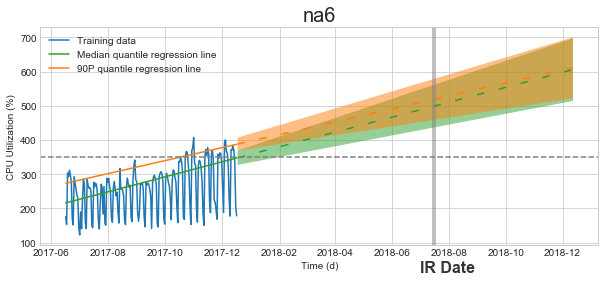

In [110]:
plt.plot(tsQuantile['ds'],tsQuantile['y'],c='#1f77b4')
#plt.plot(futureQuantile['Timestamp'],df_model_test['avg_app_cpu'],c='#ff7f0e')
plt.plot([x_start_med_line,x_end_med_line],[y_start_med_line,y_end_med_line],c='#2ca02c')
plt.plot([x_start_med_line,x_end_med_line],[y_start_extrap_line,y_end_extrap_line],c='#ff7f0e')
plt.plot([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_med_line,y_forecast_end_med_line],c='#2ca02c', linestyle='--', dashes=(5, 10))
plt.plot([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_line,y_forecast_end_extrap_line],c='#ff7f0e', linestyle='--', dashes=(5, 10))
#Bounds
plt.fill_between([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_lwr_med,y_forecast_end_extrap_lwr_med],[y_forecast_start_extrap_hghr_med,y_forecast_end_extrap_hghr_med], facecolor='#2ca02c', alpha=0.5)
plt.fill_between([x_forecast_start_med_line,x_forecast_end_med_line],[y_forecast_start_extrap_lwr_ninetyp,y_forecast_end_extrap_lwr_ninetyp],[y_forecast_start_extrap_hghr_ninetyp,y_forecast_end_extrap_hghr_ninetyp], facecolor='#ff7f0e', alpha=0.5)
plt.title(podName,fontsize=20)
plt.xlabel('Time (d)')
plt.ylabel('CPU Utilization (%)')
plt.legend(['Training data','Median quantile regression line', '90P quantile regression line'])
plt.axhline(y=50*topNodes,c='gray',linestyle='--')
plt.axvline(x=IRdate, c='gray', lw=4, alpha=0.5)
plt.text(x=(pd.to_datetime(IRdate) - pd.Timedelta('15 days')), y=15, s='IR Date', color='black', fontsize=16, fontweight='bold', alpha=0.8)
plt.grid(True)
plt.show()

In [111]:
forecast.set_index('ds', inplace=True)

In [112]:
mask_future=forecast.index>max(tsCPU2.index)
mask_model=forecast.index<=max(tsCPU2.index)
model=forecast.loc[mask_model]
future_forecast=forecast.loc[mask_future]

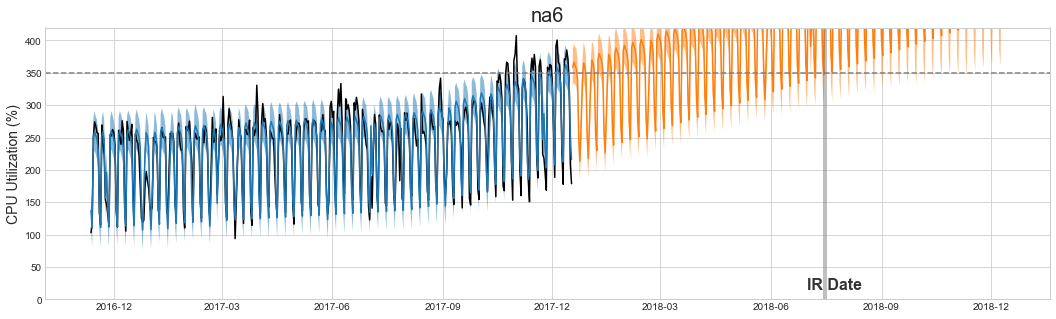

In [113]:
forecast.columns

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(18,5))

ax.plot(tsCPU2.index,tsCPU2['y'],c='black')

ax.plot(model.index,model['yhat'],c='#1f77b4')
ax.fill_between(model.index, model.yhat_lower, model.yhat_upper, facecolor='#1f77b4', alpha=.5)

ax.plot(future_forecast.index,future_forecast['yhat'],c='#ff7f0e')
ax.fill_between(future_forecast.index, future_forecast.yhat_lower, future_forecast.yhat_upper, facecolor='#ff7f0e', alpha=.5)




ax.set_ylabel('CPU Utilization (%)', fontsize=14)
ax.set_ylim(0,50*topNodes*1.2)
ax.set_title(podName , fontsize=20)
ax.axvline(x=IRdate, c='gray', lw=4, alpha=0.5)
ax.axhline(y=50*topNodes,c='gray',linestyle='--')
ax.text(x=(pd.to_datetime(IRdate) - pd.Timedelta('15 days')), y=15, s='IR Date', color='black', fontsize=16, fontweight='bold', alpha=0.8)

_ = plt.show()

In [114]:
forecast.head()

,trend,cap,trend_lower,trend_upper,yhat_lower,yhat_upper,holiday,holiday_lower,holiday_upper,holidays,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2016-11-12,212.429452,350,212.429452,212.429452,108.066432,167.230058,0.0,0.0,0.0,0.0,...,-75.025793,-75.025793,-75.025793,-75.025793,-75.025793,-75.025793,-75.025793,-75.025793,-75.025793,137.403659
2016-11-13,212.534381,350,212.534381,212.534381,81.154968,139.363988,0.0,0.0,0.0,0.0,...,-102.440280,-102.440280,-102.440280,-102.440280,-102.440280,-102.440280,-102.440280,-102.440280,-102.440280,110.094101
2016-11-14,212.639310,350,212.639310,212.639310,223.866025,280.537537,0.0,0.0,0.0,0.0,...,38.564870,38.564870,38.564870,38.564870,38.564870,38.564870,38.564870,38.564870,38.564870,251.204180
2016-11-15,212.744239,350,212.744239,212.744239,229.439801,290.875930,0.0,0.0,0.0,0.0,...,46.475032,46.475032,46.475032,46.475032,46.475032,46.475032,46.475032,46.475032,46.475032,259.219271
2016-11-16,212.849168,350,212.849168,212.849168,223.760609,282.237089,0.0,0.0,0.0,0.0,...,39.988999,39.988999,39.988999,39.988999,39.988999,39.988999,39.988999,39.988999,39.988999,252.838167


In [115]:
forecast['ds'] = forecast.index
pessimisticTTL_prophet = forecast[forecast['yhat_upper'] >= capacity]['ds'].min()
optimisticTTL_prophet = forecast[forecast['yhat'] >= capacity]['ds'].min()
(pessimisticTTL_prophet,optimisticTTL_prophet)

(Timestamp('2017-10-17 00:00:00'), Timestamp('2017-11-28 00:00:00'))

Let's save the results for each pod

In [119]:
ttl_times = [podName,pessimisticTTL_prophet, optimisticTTL_prophet, pessimisticTTL_quantile, optimisticTTL_quantile]
#fd = open('/Users/abertran/Documents/Results/ForecastResults/dbCPUUtil/ForecastResults_dbcpu.csv','a')
#fd.write(ttl_times)
#fd.close
import csv

with open('/Users/abertran/Documents/Results/ForecastResults/dbCPUUtil/ForecastResults_dbcpu.csv', 'a') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(ttl_times)